# DIIG Fall 2025 Data Challenge
## Oliver Lublin

### NetID: ol35
### Dataset: Mint Customer Analytics

# **Part 1: Cleaning Dataset**

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#let's read in the data set and get necessary information
data = pd.read_csv(f'{os.getcwd()}\\mint_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

Let's also take a look at the first 5 entries of the dataframe:

In [3]:
pd.options.display.max_columns = None
data.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


As shown, the dataframe we will be working with has 7043 observations (customers), indexed by an id. There are 9 numeric columns, 13 boolean columns (yes or no), 9 categorical columns, and one float pair (Lat Long, which we will drop shortly). We notice, with the exception of the "Churn Reason" column, that each column has 7043 non-null values, so we have no need to clean null values from rest of the dataframe.

We do notice that the "Total Charges" column has a type of "object" despite containing numeric values. We change the type of this column next.

In [4]:
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors = 'coerce').fillna(0)

Now we can get summary statistics for each of the numeric columns.

In [5]:
numeric_columns = data.select_dtypes(include=['int64','float64']).columns
data[numeric_columns].describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,2279.734304,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,2266.794470,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,398.550000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,1394.550000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,3786.600000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000,100.000000,6500.000000


We observe that the "Count" column contains all ones, so we drop it. Likewise, the "Churn Value" column contains the same information as the "Churn Label" column, so we opt to drop it.

In [6]:
data = data.drop(columns = ['Count', 'Churn Value'])

Next, we use the GeoPandas package to transform the latitude and longitude into a single column, allowing us to plot the data geospatially in the future if we so choose.

In [7]:
geometry = gpd.points_from_xy(x = data['Longitude'], y = data['Latitude'])
gdata = gpd.GeoDataFrame(data, geometry = geometry, crs = 'EPSG:4326').drop(columns = ['Lat Long', 'Latitude', 'Longitude'])
type(gdata) #check that we've produced a gdf

geopandas.geodataframe.GeoDataFrame

Lastly, we convert all of the columns storing "yes" or "no" values to booleans, which will make them easier to work with.

In [8]:
#check that all values are yes or no
is_boolean = (gdata.loc[0] == 'Yes') | (gdata.loc[0] == 'No')
boolean_list = is_boolean[is_boolean].index.to_list()
for column in boolean_list:
    print(gdata[column].unique())

['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes' 'No phone service']
['Yes' 'No' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Yes' 'No']
['Yes' 'No']


We see that some of the columns have a third option for "No phone service" or "No internet service". This counts towards "False", since clearly someone with no phone service would not have multiple lines or likewise. We can simply include these in the "False" values after conversion.

In [9]:
def str_to_boolean(string):
    if string == 'Yes':
        return True
    else:  #including "no internet" values
        return False
for column in boolean_list:
    gdata[column] = gdata[column].apply(str_to_boolean) #transforms every yes/no column to true/false

Now we've finished cleaning the dataframe to what we want. These are the changes: 
- dropped "Count" column
- transformed "Latitude" and "Longitude" columns to "Geometry" column to produce geospatial dataframe
- converted all "Yes" and "No" values to booleans.

Let's get a peek at what our GeoDataFrame looks like now (it's important to check changes every so often).

In [10]:
gdata.head()

,CustomerID,Country,State,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,geometry
0,3668-QPYBK,United States,California,Los Angeles,90003,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.85,108.15,True,86,3239,Competitor made better offer,POINT (-118.27 33.964)
1,9237-HQITU,United States,California,Los Angeles,90005,Female,False,False,True,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.70,151.65,True,67,2701,Moved,POINT (-118.31 34.059)
2,9305-CDSKC,United States,California,Los Angeles,90006,Female,False,False,True,8,True,True,Fiber optic,False,False,True,False,True,True,Month-to-month,True,Electronic check,99.65,820.50,True,86,5372,Moved,POINT (-118.29 34.048)
3,7892-POOKP,United States,California,Los Angeles,90010,Female,False,True,True,28,True,True,Fiber optic,False,False,True,True,True,True,Month-to-month,True,Electronic check,104.80,3046.05,True,84,5003,Moved,POINT (-118.32 34.062)
4,0280-XJGEX,United States,California,Los Angeles,90015,Male,False,False,True,49,True,True,Fiber optic,False,True,True,False,True,True,Month-to-month,True,Bank transfer (automatic),103.70,5036.30,True,89,5340,Competitor had better devices,POINT (-118.27 34.039)


# **Part 2: Exploratory Data Analysis**

We now conduct univariate data analysis on each of the 5 numeric variables we care about. For each numeric variable, we make a kernel density plot utilizing the python library seaborn. A kernel density plot estimates the probability density function of each variable as a continuous function. This will give us a good idea of the modality and skewness of each of the numeric variables.

The numeric columns we care about are: Tenure Months, Monthly Charges, Total Charges, Churn Score, and CLTV

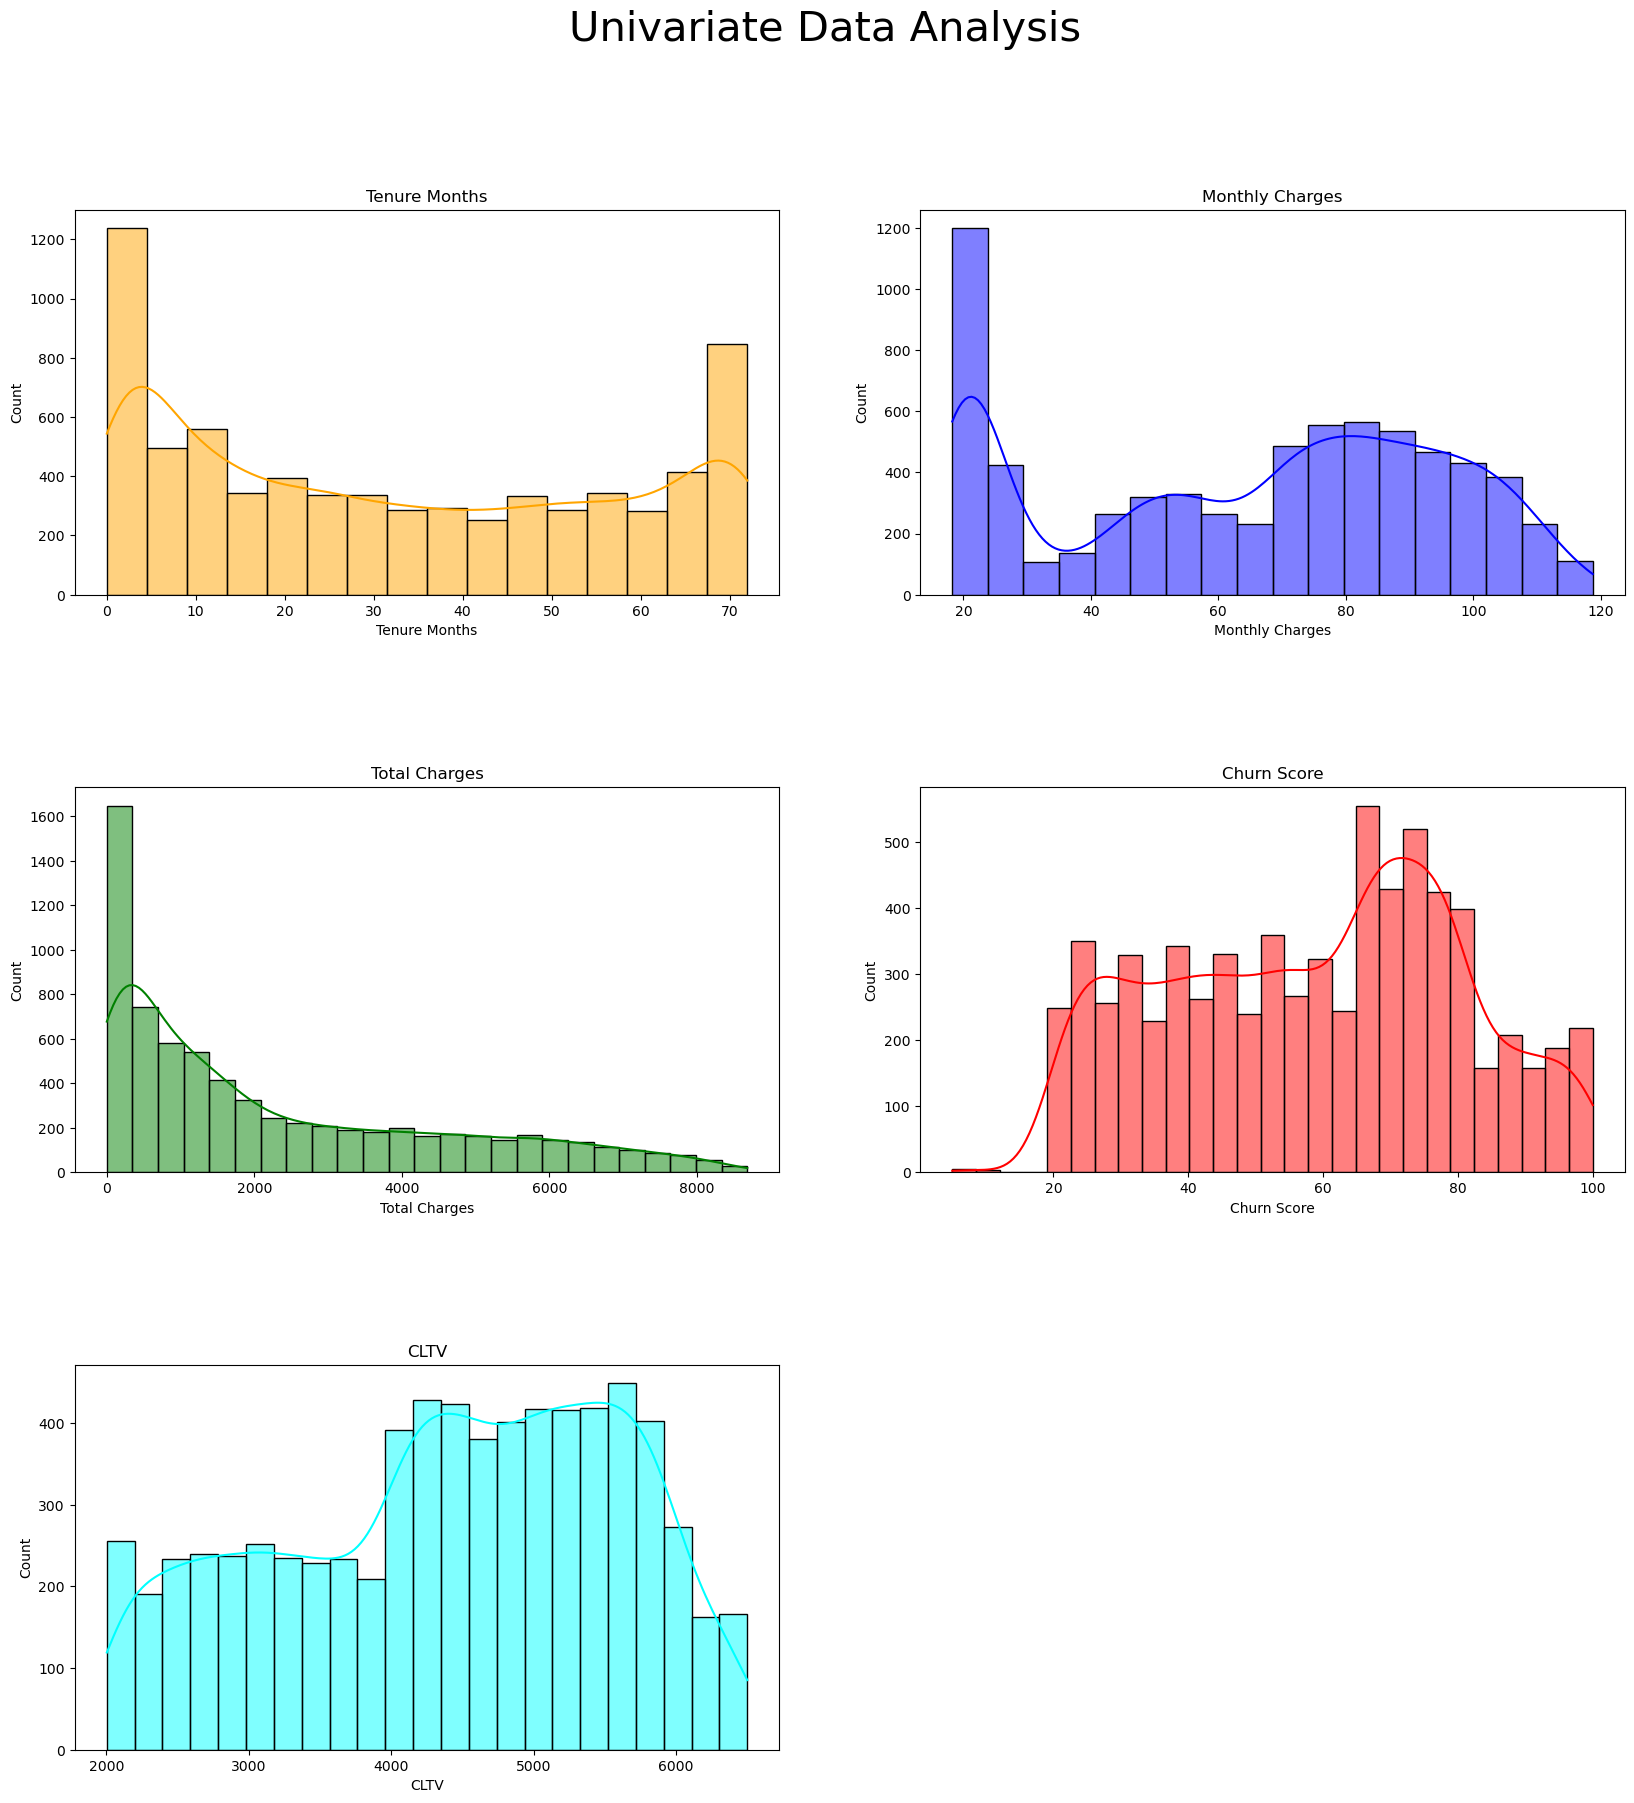

In [11]:
fig = plt.figure(figsize = (20,20)) 
colors = list({'blue','green','red','cyan','pink','orange','brown'})
columns_to_plot = ['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']    #only care about the last 5 numeric columns

for index, column in enumerate(columns_to_plot):
    plt.subplot(3,2,index+1),
    sns.histplot(data[column], color = colors[index], kde = True),  #this will iteratively plot the histogram and kernel density function.
    plt.title(column)

fig.suptitle('Univariate Data Analysis', fontsize = 30)
plt.subplots_adjust(wspace = 0.2,hspace = 0.5) #seperate subplots with a little space
plt.show()

**Conclusions:**

- The distribution of tenure months is bimodal, with the most customers cancelling shortly after enrolling (within 5 months) or staying on for at least ~70 months.

- The distribution of monthly charges is also bimodal, with a peak at around 20 dollars/month and another peak at around 80 dollars/month. This makes me suspect that 20 dollars is the base monthly charge, and all customers paying roughly 20 dollars/month are ones who rarely if ever use their phones.

- The distribution of total charges is unimodal and steadily decreases. It is heavily skewed right.

- The distribution of churn scores is unimodal with a peak at around 70, but is relatively constant throughout. 

- The distribution of CLTV (Customer Lifetime Value) has a similar distribution to churn scores, with a plateaud peak from 4000 to 6000.

Next, to get a general idea of correlation between all of our features, let's make a correlation matrix. This shows how much each feature is correlated with each other feature. We really want to focus on how "Churn Label" (whether the customer churned or not) 

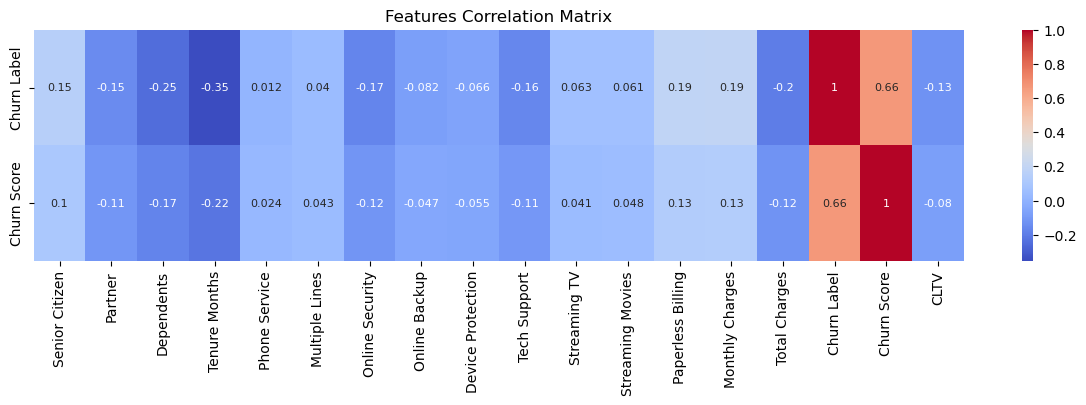

In [12]:
features = gdata.select_dtypes(include=['bool','int64','float64']).columns.drop('Zip Code')

plt.figure(figsize = (15,3))
corr_matrix = gdata[features].corr()
subset = corr_matrix.iloc[15:17,:]
sns.heatmap(subset,cmap = 'coolwarm',annot = True, annot_kws = {'fontsize':8})
plt.title('Features Correlation Matrix')

plt.savefig('corr_matrix.png')

Observations:

- Note that having a partner and dependents are correlated with churning less often. Senior citizens, meanwhile, tend to churn more often.

- Long-time customers have high lifetime values. Tenure months is the feature most correlated with a decrease in "Churn Label", meaning long-time customers are less likely to churn (as would be expected).

- Having tech support and online security is correlated with churning less often, while customers utilizing paperless billing are correlated with churning more often

Let's take a look at the first observation to start. We can gather observations from the four possible combinations of having/not having dependents and having/not having a partner and look at the percent of each that churned.

Text(0.5, 1.0, 'Percent of Customers Churning by Partner and Dependency Status')

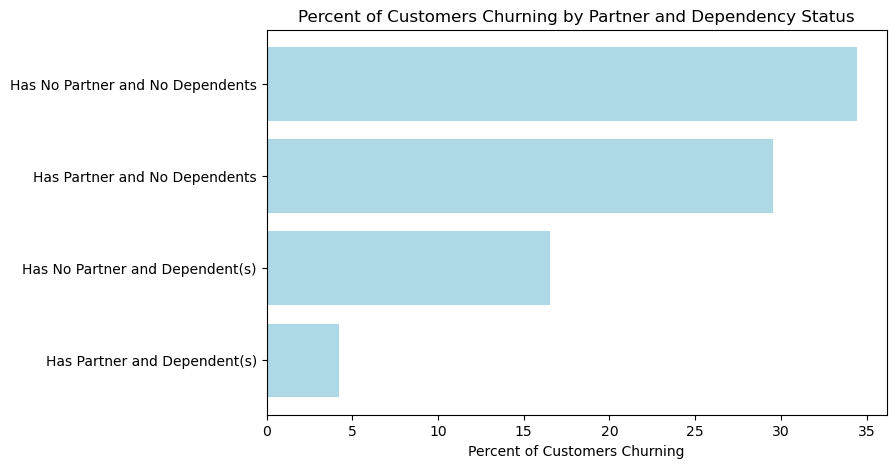

In [13]:
part_dep = gdata[(gdata['Partner'] == True) & (gdata['Dependents'] == True)]
part_no_dep = gdata[(gdata['Partner'] == True) & (gdata['Dependents'] == False)]
no_part_dep = gdata[(gdata['Partner'] == False) & (gdata['Dependents'] == True)]
no_part_no_dep = gdata[(gdata['Partner'] == False) & (gdata['Dependents'] == False)]

def pct_churning(df):
    return 100*df['Churn Label'].sum()/len(df)  #get the number of customers churning by summing over the boolean 'Churn Label'.

churning_pcts = {
    'Has Partner and Dependent(s)': pct_churning(part_dep),
    'Has No Partner and Dependent(s)': pct_churning(no_part_dep),
    'Has Partner and No Dependents': pct_churning(part_no_dep),
    'Has No Partner and No Dependents': pct_churning(no_part_no_dep)
}

fig, ax = plt.subplots(figsize = (8,5))
ax.set_xlabel('Percent of Customers Churning')
plt.barh(churning_pcts.keys(),churning_pcts.values(), color = 'lightblue')

plt.title('Percent of Customers Churning by Partner and Dependency Status')

Customers with no partner and no dependents are more than 8 times more likely to churn than customers with a partner and dependent(s). This difference is even more stark than the -0.15 and -0.25 correlation we observed between churning and partner status and dependency status, respectively.

Now we turn to our second point: Customers with longer tenures and lower spending tend to churn less. After testing several plots, I decided on a segmented 2d plot. This essentially uses the pd.cut function to segment the dataframe into 10 equally sized bins for both tenure and monthly charges, then plots the percent of percent of customers churning for each bin in a heatmap.


In [14]:
gdata.tail()

,CustomerID,Country,State,City,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Score,CLTV,Churn Reason,geometry
7038,2569-WGERO,United States,California,Landers,92285,Female,False,False,False,72,True,False,No,False,False,False,False,False,False,Two year,True,Bank transfer (automatic),21.15,1419.40,False,45,5306,NaN,POINT (-116.54 34.342)
7039,6840-RESVB,United States,California,Adelanto,92301,Male,False,True,True,24,True,True,DSL,True,False,True,True,True,True,One year,True,Mailed check,84.80,1990.50,False,59,2140,NaN,POINT (-117.54 34.668)
7040,2234-XADUH,United States,California,Amboy,92304,Female,False,True,True,72,True,True,Fiber optic,False,True,True,False,True,True,One year,True,Credit card (automatic),103.20,7362.90,False,71,5560,NaN,POINT (-115.64 34.56)
7041,4801-JZAZL,United States,California,Angelus Oaks,92305,Female,False,True,True,11,False,False,DSL,True,False,False,False,False,False,Month-to-month,True,Electronic check,29.60,346.45,False,59,2793,NaN,POINT (-116.86 34.168)
7042,3186-AJIEK,United States,California,Apple Valley,92308,Male,False,False,False,66,True,False,Fiber optic,True,False,True,True,True,True,Two year,True,Bank transfer (automatic),105.65,6844.50,False,38,5097,NaN,POINT (-117.18 34.425)


In [15]:
gdata[gdata['Contract'] == 'Two year']['Monthly Charges'].mean()

60.770412979351036

In [16]:
copy = gdata.copy()

copy['Tenure Bins'] = pd.cut(copy['Tenure Months'], bins = 10)
copy['Charges Bins'] = pd.cut(copy['Monthly Charges'], bins = 10)
bins = copy.groupby(['Tenure Bins', 'Charges Bins'], as_index = False)['Churn Label'].mean() #gets pct churning for each bin
bins = bins.rename(columns = {'Churn Label':'Percent Churning'})
bins['Percent Churning'] = 100*bins['Percent Churning'] #convert to pct
bins

C:\Users\olubl\AppData\Local\Temp\ipykernel_19804\2132911684.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bins = copy.groupby(['Tenure Bins', 'Charges Bins'], as_index = False)['Churn Label'].mean() #gets pct churning for each bin


,Tenure Bins,Charges Bins,Percent Churning
0,"(-0.072, 7.2]","(18.15, 28.3]",25.874126
1,"(-0.072, 7.2]","(28.3, 38.35]",50.000000
2,"(-0.072, 7.2]","(38.35, 48.4]",51.923077
3,"(-0.072, 7.2]","(48.4, 58.45]",44.897959
4,"(-0.072, 7.2]","(58.45, 68.5]",27.586207
...,...,...,...
95,"(64.8, 72.0]","(68.5, 78.55]",4.054054
96,"(64.8, 72.0]","(78.55, 88.6]",4.605263
97,"(64.8, 72.0]","(88.6, 98.65]",7.913669
98,"(64.8, 72.0]","(98.65, 108.7]",16.145833


Now that we have all the bins with their churning values, we need to index the dataframe and set column values. We can do this with pd.pivot.

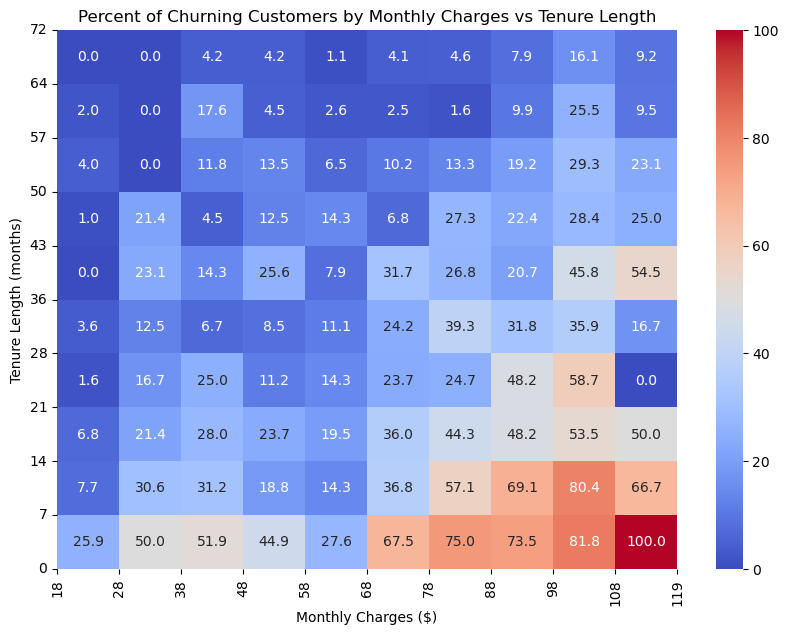

In [17]:
bins_pivot = bins.pivot(index = 'Tenure Bins', columns = 'Charges Bins', values = 'Percent Churning')

fig, ax = plt.subplots(figsize = (10,7))

sns.heatmap(bins_pivot,cmap = 'coolwarm', annot = True, fmt = '.1f') #fmt: number of decimals

ax.set_xlabel('Monthly Charges ($)')
ax.set_ylabel('Tenure Length (months)')

ax.set_xticks(np.array(range(11))) #set ticks at bin boundaries
ax.set_yticks(np.array(range(11)))
ax.set_xticklabels([int(interval.left) for interval in bins['Charges Bins'].unique()] + [119]) #add last tick manually
ax.set_yticklabels([int(interval.left) for interval in bins['Tenure Bins'].unique()] + [72])

ax.invert_yaxis() #make tenure length increasing as we go up

plt.title('Percent of Churning Customers by Monthly Charges vs Tenure Length')
plt.show()


This plot says a lot about the relation between monthly charges, tenure length, and churning expectancy. High monthly charges and short tenure lengths are a good predictor of churning, especially in conjunction.

There are a few more features I want to take a closer look at, specifically two columns known at the initialization of the contract. While we won't have monthly charges and tenure data until later on, we know what contract duration the customer purchaced with what payment method from the very start. Let's take a look at if there is a significant difference between the percent of churning customers by each of these. 

In [18]:
payments = {}
for payment in gdata['Payment Method'].unique():
    payments[payment] = sum(gdata[gdata['Payment Method'] == payment]['Churn Label'])/sum(gdata['Payment Method'] == payment)
payments

{'Mailed check': 0.19106699751861042,
 'Electronic check': 0.4528541226215645,
 'Bank transfer (automatic)': 0.16709844559585493,
 'Credit card (automatic)': 0.15243101182654403}

In [19]:
contracts = {}
for contract in gdata['Contract'].unique():
    contracts[contract] = sum(gdata[gdata['Contract'] == contract]['Churn Label'])/sum(gdata['Contract'] == contract)
contracts

{'Month-to-month': 0.4270967741935484,
 'Two year': 0.02831858407079646,
 'One year': 0.11269517990495587}

We do see that in both of these variables, there is a significant difference between one of the categorical variables and the others. While 45% of customers paying by electronic check churn, less than 20% of customers using all other payment methods do. Likewise, while 42% of customers purchasing monthly contracts churn, less than 3% of customers purchasing two-year contracts do. This seems intuitive, based on our earlier observation that customers with longer tenures are less likely to churn.

# **Part 3: Random Forest ML Modeling**

Now that we've analyzed our data on both a univariate and multivariate basis, it's an appropriate time to build a model to try to predict whether a customer will churn or not. 


Since we are attempting to do binary classification (predict whether customers will churn or not) and have so many boolean variables present in the dataset already, a random forest is an appropriate machine learning model to use. Random forests combine multiple decision trees split at nodes based on a random combination of features.


Also, from the previous code, we can see that it is important to include some categorical variables as well (payment type, contract type). Random forests don't work well with categorical variables, but we can encode these values into dummy variables using one-hot encoding, which makes new columns for each possible value and replaces them with True or False based on if the customer used each respective payment method. In the following cell, I manually encode the categorical variables for payment method and contract type into new boolean columns.

In [20]:
#manual one-hot encoding
for payment_method in gdata['Payment Method'].unique():
    gdata[payment_method] = (gdata['Payment Method'] == payment_method)  #return true if this customer used a given payment method
for contract in gdata['Contract'].unique():
    gdata[contract] = (gdata['Contract'] == contract)

This adds 4 new columns of booleans given by whether each row uses each of the 4 payment methods. Now we set our model features and our target. We aim to predict whether the customer churned or not ("churn label"), so that is our target. For our predictions, we will use all boolean features in the dataset (including the encoded payment methods and contract durations). We avoid using the numeric columns "Tenure Months" and "Monthly Charges", as we don't have this data at the start of the contract and can't use it as well to make actionable recommendations.

In [21]:
target = ['Churn Label']
features = gdata.select_dtypes('bool').columns.to_list() 
features.remove('Churn Label') #features include all boolean variables except churn label (our target variable)

X = gdata[features]
y = gdata[target]

Now, it's time to train our model. First, we use the train_test_split module in Scikit-learn to split the data into random training and testing subsets. We fit our model and print out two model evaluation metrics, the classification report and confusion matrix, which is necessary to tell us how effective our model is at predictions.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, np.ravel(y), random_state=1        #splits data into random training and testing subsets
)

rf = RandomForestClassifier(
    n_estimators=200,     #count of trees in forest   
    min_samples_split=10, #min samples required to split internal node        
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test) #predict churning based on training subset of X

#compare predicted to actual values
print(classification_report(y_test, y_pred)) 
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.88      0.86      1317
        True       0.58      0.48      0.52       444

    accuracy                           0.78      1761
   macro avg       0.70      0.68      0.69      1761
weighted avg       0.77      0.78      0.77      1761

[[1159  158]
 [ 230  214]]


We can interpret the classification matrix as:

- Precision (false): pct of customers predicted to stay who did indeed stay
- Precision (true): pct of customers predicted to churn who did indeed churn


- Recall (false): pct of staying customers who were predicted to stay
- Recall (true): pct of churning customers who were predicted to churn

In the case of predicting churning, we want a high true recall to spot churners. Our true recall of 0.49 is a bit low, so we decrease the probability threshold for the model to mark an observation as a churner.

As is, the model simply requires a probability of churning of at least 0.5 to classify an observation as a churner. By decreasing this, we can catch more potential churners. We use the Scikit-learn "predict_proba" object to alter this threshold.

In [23]:
?RandomForestClassifier.predict_proba

Signature: RandomForestClassifier.predict_proba(self, X)
Docstring:
Predict class probabilities for X.

The predicted class probabilities of an input sample are computed as
the mean predicted class probabilities of the trees in the forest.
The class probability of a single tree is the fraction of samples of
the same class in a leaf.

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples, n_features)
    The input samples. Internally, its dtype will be converted to
    ``dtype=np.float32``. If a sparse matrix is provided, it will be
    converted into a sparse ``csr_matrix``.

Returns
-------
p : ndarray of shape (n_samples, n_classes), or a list of such arrays
    The class probabilities of the input samples. The order of the
    classes corresponds to that in the attribute :term:`classes_`.
File:      c:\users\olubl\anaconda3\envs\spatialdata\lib\site-packages\sklearn\ensemble\_forest.py
Type:      function

In [24]:
y_probs = rf.predict_proba(X_test)
y_probs

array([[0.71950667, 0.28049333],
       [0.52538486, 0.47461514],
       [0.98377554, 0.01622446],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.80355547, 0.19644453]])

The first column is the probability that an observation is not a churner, and the second column is the probability an observation is a churner. We want to change the minimum from the second column from 0.5 to 0.4 to improve our recall and catch more churners.

In [25]:
y_threshold = (y_probs[:,1] > 0.4).astype(int) #returns 0 if value is under 0.4, 1 if value is over 0.4
print(classification_report(y_test, y_threshold)) 
print(confusion_matrix(y_test, y_threshold))

              precision    recall  f1-score   support

       False       0.87      0.81      0.84      1317
        True       0.52      0.64      0.57       444

    accuracy                           0.76      1761
   macro avg       0.70      0.72      0.70      1761
weighted avg       0.78      0.76      0.77      1761

[[1061  256]
 [ 162  282]]


This threshold catches 65% of churners, which is better, but at the sacrifice of less precision in catching churners (more non-churners are also predicted as churners). We can fine tune the parameters as necessary to get the outcome we want.

Let's use the "feature_importances_" object in RandomForestClassifier to get the importances of each feature. This will help us see which categories are most important for predicting churning.

Text(0.5, 1.0, 'Random Forest Classifier Feature Importances')

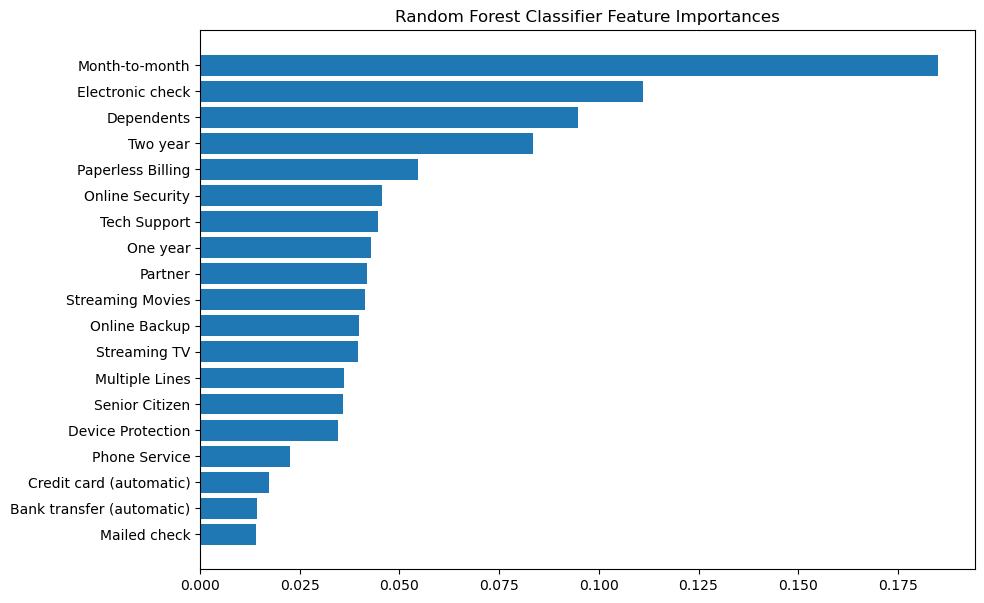

In [26]:
importances = rf.feature_importances_
names = X.columns
importances_df = pd.DataFrame({'Features': names, 
                               'Importances': importances}
                             ).sort_values(by = 'Importances', ascending = True)

plt.figure(figsize = (10,7))
plt.barh(
    y = importances_df['Features'],
    width = importances_df['Importances']
)

plt.title('Random Forest Classifier Feature Importances')

Lastly, we do an example prediction, taking a random entry in our entire dataset and predicting whether this customer is a churner.

In [27]:
ex = gdata.iloc[[1240]][features]
ex

,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Paperless Billing,Mailed check,Electronic check,Bank transfer (automatic),Credit card (automatic),Month-to-month,Two year,One year
1240,True,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False


In [28]:
rf.predict(ex)

array([ True])

This example is a correct prediction - a senior citizen who is married but without dependents, signed on to a month-to-month contract with an automatic bank transfer, who ended up switching out of the phone plan. 